In [2]:
%pip install --upgrade --quiet langchain langchain-community langchainhub beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


Selecting Chat Model

In [3]:
pip install -qU "langchain[google-genai]"

Note: you may need to restart the kernel to use updated packages.


In [1]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

Selecting Embedding Model

In [2]:
pip install -qU langchain-google-genai

Note: you may need to restart the kernel to use updated packages.


In [3]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

Selecting Vector Store

In [4]:
pip install -qU langchain-core

Note: you may need to restart the kernel to use updated packages.


In [5]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## RAG Application

First we index our documents:

In [7]:

import os
from typing import List
from fastapi import UploadFile
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.memory import ConversationBufferMemory
from langchain_groq import ChatGroq
from langchain.chains import ConversationalRetrievalChain
from langgraph.checkpoint.memory import MemorySaver
from langchain.chains import ConversationChain

In [ ]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
# loader = WebBaseLoader(
#     web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
#     bs_kwargs=dict(
#         parse_only=bs4.SoupStrainer(
#             class_=("post-content", "post-title", "post-header")
#         )
#     ),
# )
# docs = loader.load()

# Trying different load

ALL_DOCS = []
async def load_docs(files: List[UploadFile]):
    global ALL_DOCS
    os.makedirs("tmp", exist_ok=True)
    ALL_DOCS = []  # Reset on each upload
    for file in files:
        file_path = os.path.join("tmp", file.filename)
        with open(file_path, "wb") as f:
            f.write(await file.read())
        loader = PyPDFLoader(file_path)
        docs = loader.load()
        ALL_DOCS.extend(docs)
    return {"status": "success", "num_files": len(files), "num_docs": len(ALL_DOCS)}

def get_loaded_docs():
    return ALL_DOCS


text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

NameError: name 'docs' is not defined

In [10]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

Next we build a simple graph without citing the main source:

In [11]:
from langchain import hub
from langchain_core.documents import Document
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

c:\Users\rohit\anaconda3\envs\kyojinai\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


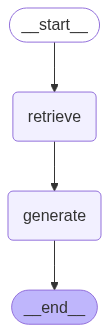

In [12]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Get Answer and Context

In [13]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='70f34c65-223e-4649-a711-e90400350001', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availab

Get Answer, Context and Main Source

In [14]:
from typing import List

from typing_extensions import Annotated, TypedDict


# Desired schema for response
class AnswerWithSources(TypedDict):
    """An answer to the question, with sources."""

    answer: str
    sources: Annotated[
        List[str],
        ...,
        "List of sources (author + year) used to answer the question",
    ]


class State(TypedDict):
    question: str
    context: List[Document]
    answer: AnswerWithSources


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    structured_llm = llm.with_structured_output(AnswerWithSources)
    response = structured_llm.invoke(messages)
    return {"answer": response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [15]:
import json

result = graph.invoke({"question": "What is Chain of Thought?"})
print(json.dumps(result["answer"], indent=2))

{
  "sources": [
    "Wei et al. 2022"
  ],
  "answer": "Chain of Thought (CoT) is a prompting technique that enhances model performance on complex tasks. It instructs the model to \"think step by step\" to break down difficult tasks into smaller, simpler steps. CoT transforms large tasks into multiple manageable ones, offering insight into the model's thinking process."
}


In [18]:
print(result["context"])

[Document(id='d04ca08a-f837-4e13-b5e3-64014b5a0694', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-f